In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

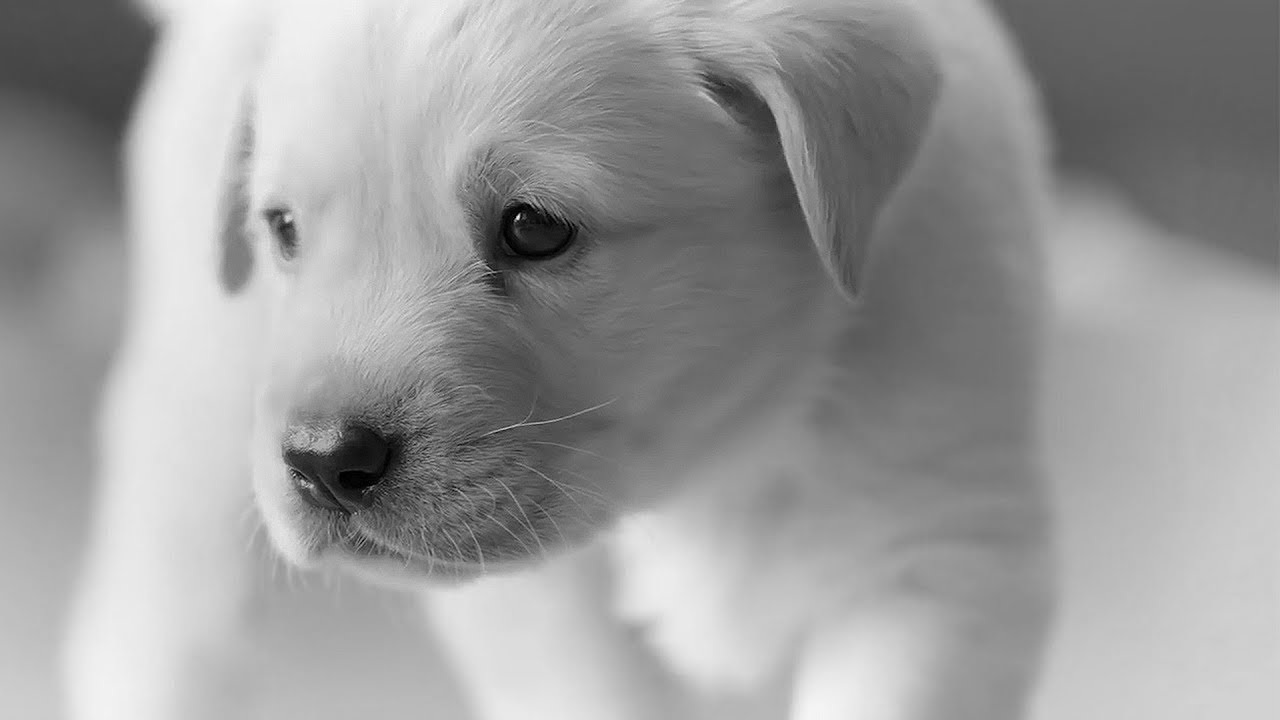

In [2]:
img = cv2.imread('imgs/dog.jpg',0)
Image.fromarray(img)

In [3]:
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

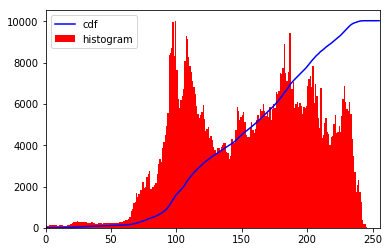

In [4]:
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')

In [5]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = cdf[img]

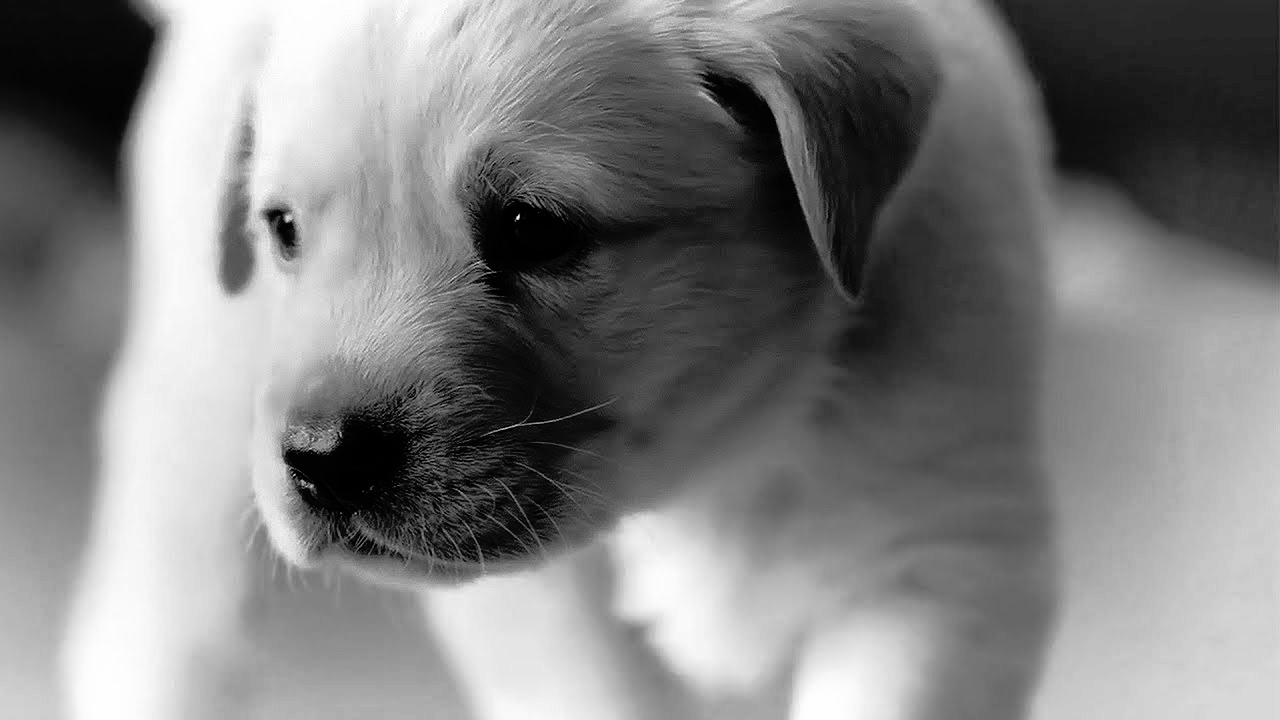

In [6]:
Image.fromarray(img2)

### Aplicando a equalização do Histograma com o OpenCV

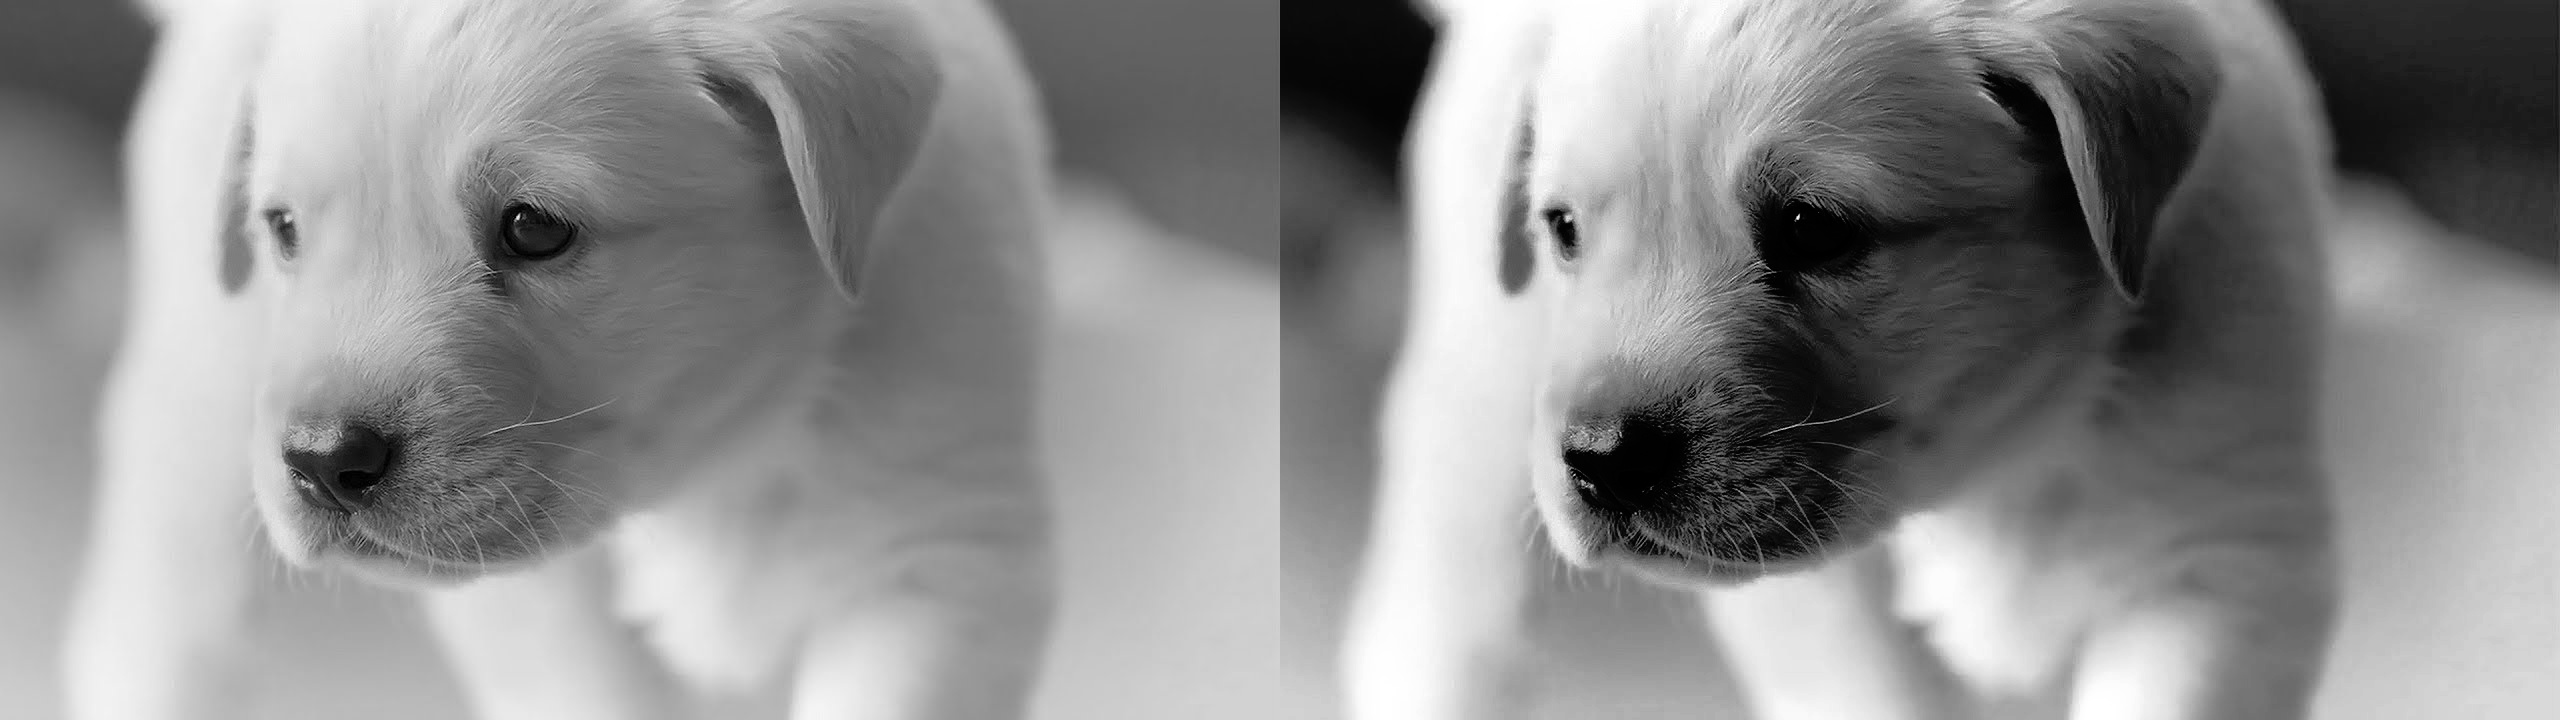

In [7]:
img = cv2.imread('imgs/dog.jpg',0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
Image.fromarray(res)

### CLAHE (Contrast Limited Adaptive Histogram Equalization)

O primeiro tipo de equalização que vimos, considera o contraste global da imagem. Em muitos casos, não é uma boa idéia.

Veja o caso abaixo:

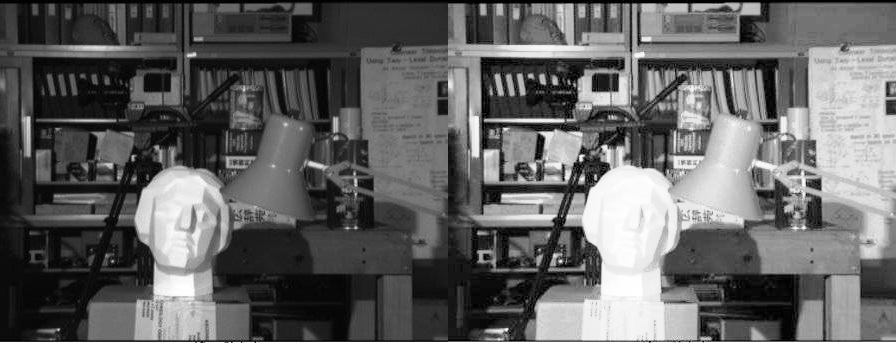

In [8]:
img = cv2.imread('imgs/clahe_sculpture.jpg',0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
Image.fromarray(res)

It is true that the background contrast has improved after histogram equalization. But compare the face of statue in both images. We lost most of the information there due to over-brightness. It is because its histogram is not confined to a particular region as we saw in previous cases (Try to plot histogram of input image, you will get more intuition).

So to solve this problem, adaptive histogram equalization is used. In this, image is divided into small blocks called “tiles” (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied.

Below code snippet shows how to apply CLAHE in OpenCV:

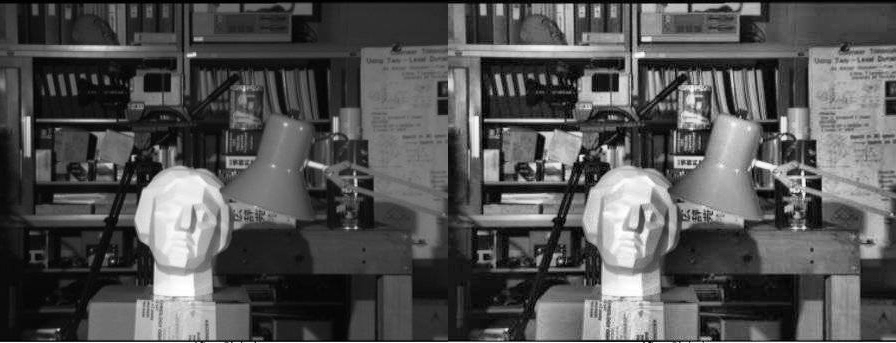

In [9]:
img = cv2.imread('imgs/clahe_sculpture.jpg',0)

# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
res = np.hstack((img,cl1))

Image.fromarray(res)

### Histogram Matching

In [10]:
def hist_match(original, specified):
 
    oldshape = original.shape
    original = original.ravel()
    specified = specified.ravel()
 
    # get the set of unique pixel values and their corresponding indices and counts
    s_values, bin_idx, s_counts = np.unique(original, return_inverse=True,return_counts=True)
    t_values, t_counts = np.unique(specified, return_counts=True)
 
    # Calculate s_k for original image
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    
    # Calculate s_k for specified image
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
 
    # Round the values
    sour = np.around(s_quantiles*255)
    temp = np.around(t_quantiles*255)
    
    # Map the rounded values
    b=[]
    for data in sour[:]:
        b.append(find_nearest_above(temp,data))
    b= np.array(b,dtype='uint8')
 
    return b[bin_idx].reshape(oldshape)

def find_nearest_above(my_array, target):
    diff = my_array - target
    mask = np.ma.less_equal(diff, -1)
    # We need to mask the negative differences
    # since we are looking for values above
    if np.all(mask):
        c = np.abs(diff).argmin()
        return c # returns min index of the nearest if target is greater than any value
    masked_diff = np.ma.masked_array(diff, mask)
    return masked_diff.argmin()

### Histogram Matching com Equalization

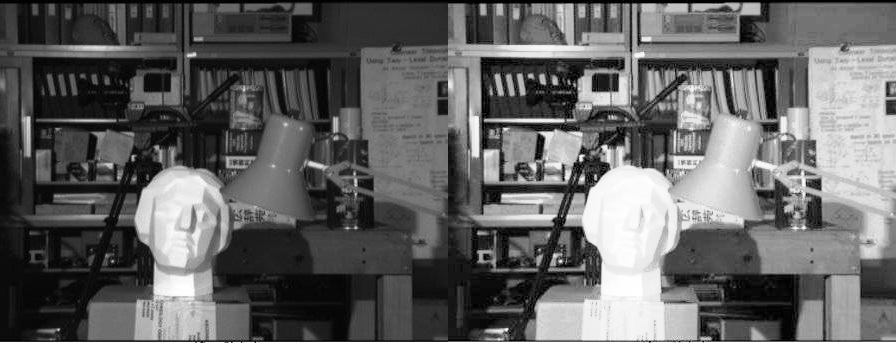

In [15]:
img = cv2.imread('imgs/clahe_sculpture.jpg',0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
Image.fromarray(res)

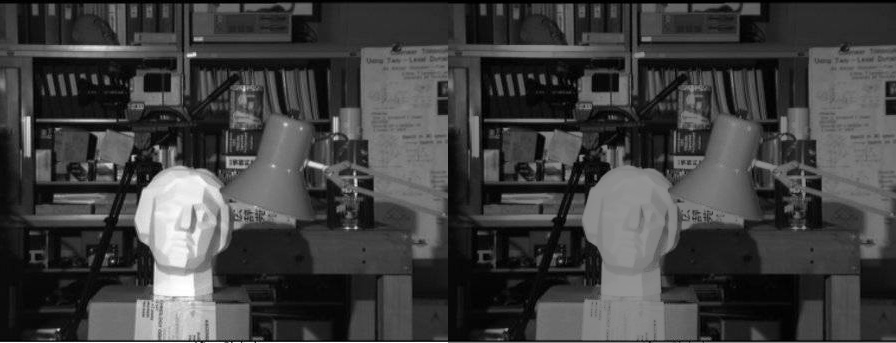

In [17]:
res = hist_match(img, equ)
res = np.hstack((img, res))
Image.fromarray(res)

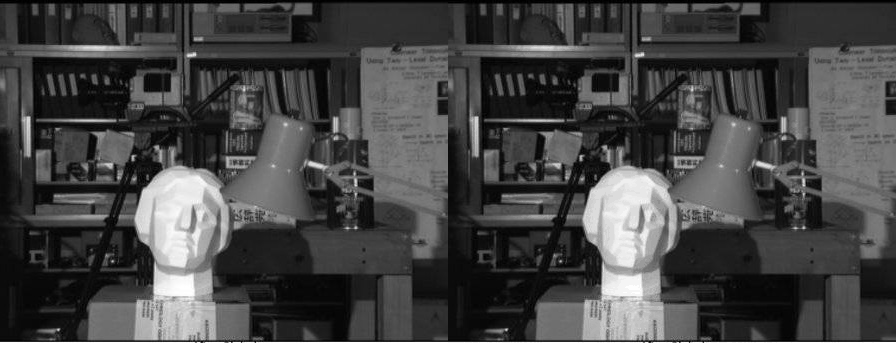

In [18]:
res = hist_match(equ, img)
res = np.hstack((img, res))
Image.fromarray(res)

### Color Repaint com o uso de Histogram Matching

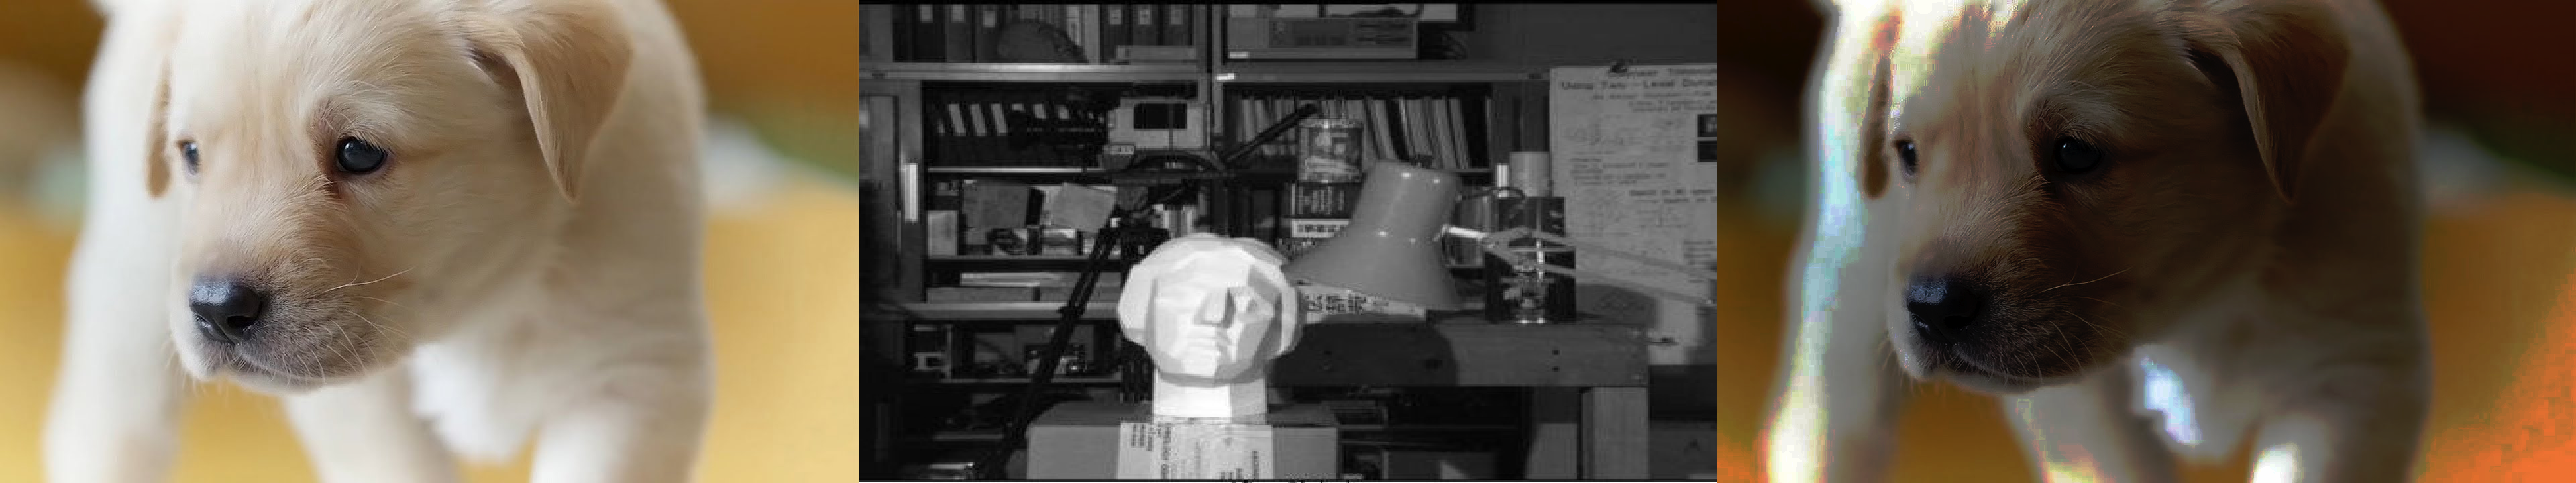

In [34]:
img = cv2.imread('imgs/dog.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('imgs/clahe_sculpture.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

### Aplicando uma correção de resize em tempo real
if img.shape > img2.shape:
    img2 = np.array(Image.fromarray(img2).resize(size=[img.shape[1], img.shape[0]]))
else:
    img = np.array(Image.fromarray(img).resize(size=[img.shape[1], img2.shape[0]]))
    
res = hist_match(img, img2)
  
### Compondo o output
res = np.hstack((img, img2, res))
Image.fromarray(res)

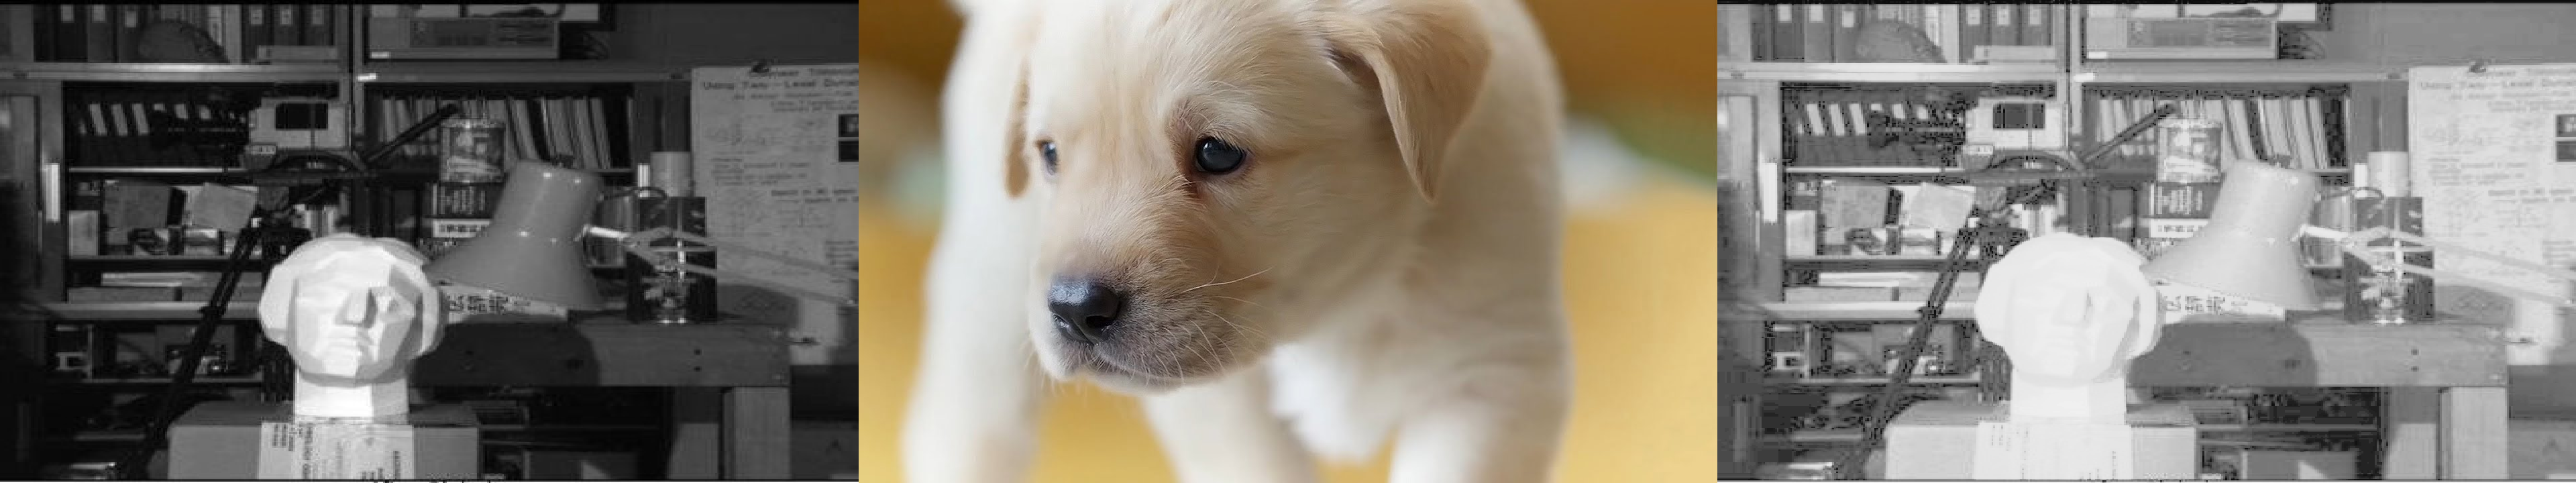

In [36]:
img = cv2.imread('imgs/dog.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('imgs/clahe_sculpture.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

### Aplicando uma correção de resize em tempo real
if img.shape > img2.shape:
    img2 = np.array(Image.fromarray(img2).resize(size=[img.shape[1], img.shape[0]]))
else:
    img = np.array(Image.fromarray(img).resize(size=[img.shape[1], img2.shape[0]]))

res = hist_match(img2, img)
    
### Compondo o output
res = np.hstack((img2, img, res))
Image.fromarray(res)